## Annother try to predict stock pris by decision tree
### Vol. 2
#### 30.06.19

In [1]:
# connecting nessesary paceges
import datetime as dt
from functools import reduce
from pandas import read_csv as read
from pandas import DataFrame as DF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.tree import export_graphviz
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from IPython.display import SVG
from IPython.display import display
from graphviz import Source
from IPython.display import HTML
style = "<style>svg{width:80% !important;height:80% !important;}</style>"
HTML(style)

In [2]:
# load data from github
gazp = read('https://raw.githubusercontent.com/Aurilino/Python/master/Annother_decision_tree/GAZP.txt')
gazp['<DATE>'] = pd.to_datetime(gazp['<DATE>'], format='%Y%m%d')
gazp.index = gazp['<DATE>']
sber = read('https://raw.githubusercontent.com/Aurilino/Python/master/Annother_decision_tree/SBER.txt')
sber['<DATE>'] = pd.to_datetime(sber['<DATE>'], format='%Y%m%d')
sber.index = sber['<DATE>']
luko = read('https://raw.githubusercontent.com/Aurilino/Python/master/Annother_decision_tree/LKOH.txt')
luko['<DATE>'] = pd.to_datetime(luko['<DATE>'], format='%Y%m%d')
luko.index = luko['<DATE>']
gazp['Day'] = gazp['<DATE>'].dt.dayofweek
sber['Day'] = gazp['<DATE>'].dt.dayofweek
luko['Day'] = gazp['<DATE>'].dt.dayofweek
for col in ['<TICKER>', '<PER>', '<TIME>', '<DATE>']:
    del luko[col]
    del sber[col]
    del gazp[col]

## Get 1 if open price upper that yestarday close price

In [3]:
gazp_grow = [float('nan')]
for i in range(1,len(gazp.index)):
    if gazp.iloc[i, 0] > gazp.iloc[i-1, 3]:
        gazp_grow.append(1)
    else:
        gazp_grow.append(0)
sber_grow = [float('nan')]
for i in range(1,len(sber.index)):
    if sber.iloc[i, 0] > sber.iloc[i-1, 3]:
        sber_grow.append(1)
    else:
        sber_grow.append(0)
luko_grow = [float('nan')]
for i in range(1,len(luko.index)):
    if luko.iloc[i, 0] > luko.iloc[i-1, 3]:
        luko_grow.append(1)
    else:
        luko_grow.append(0)

In [4]:
gazp['grow'] = gazp_grow
gazp['grow'] = gazp['grow'].shift(-1)
sber['grow'] = sber_grow
sber['grow'] = sber['grow'].shift(-1)
luko['grow'] = luko_grow
luko['grow'] = luko['grow'].shift(-1)
gazp = gazp.dropna()
sber = sber.dropna()
luko = luko.dropna()

In [5]:
luko = luko.applymap(int)
sber = sber.applymap(int)
gazp = gazp.applymap(int)

In [6]:
gazp.head()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,Day,grow
<DATE>,,,,,,,
2006-01-23,239,239,218,218,5078252,0,1
2006-01-24,220,224,219,224,8971078,1,1
2006-01-25,225,231,225,228,15467697,2,1
2006-01-26,228,229,223,224,7585458,3,1
2006-01-27,226,231,224,228,12719299,4,1


In [7]:
sber.head()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,Day,grow
<DATE>,,,,,,,
2006-01-23,43500,43500,41600,41800,30617,0,1
2006-01-24,42289,43199,41902,42797,31296,1,1
2006-01-25,43050,43500,42500,43306,27270,2,0
2006-01-26,43225,43300,42506,42610,24919,3,1
2006-01-27,42650,43907,42650,43500,22437,4,1


In [8]:
luko.head()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,Day,grow
<DATE>,,,,,,,
2006-01-23,2190,2205,2145,2145,3019295,0,1
2006-01-24,2175,2176,2146,2161,2910559,1,1
2006-01-25,2167,2199,2121,2180,5050463,2,0
2006-01-26,2171,2194,2165,2170,2318395,3,1
2006-01-27,2185,2246,2182,2241,4823314,4,1


## Claculate the strategy

In [9]:
clf = Tree(criterion='entropy')

In [10]:
c = 100000
position = 0
shares = 0
step = 100
start = 0
finish = start + step
gazp_result = []
while finish < len(gazp):
    # block of calculation
    train = gazp.iloc[start:finish, :]
    x_train = train.drop('grow', axis=1)
    y_train = train.grow
    clf.fit(x_train, y_train)
    test = DF(gazp.iloc[finish, :]).T
    x_test = test.drop('grow', axis=1)
    y_test = test.grow
    start += 1
    finish += 1
    y_pred = clf.predict(x_test)[0]
    # close position block
    if position != 0:
        c += shares * int(x_test['<OPEN>'])
        gazp_result.append(c)
        position = 0
    # open position block
    if y_pred == 1:
        if position == 0:
            shares = c // int(x_test['<CLOSE>'])
            c -= shares * int(x_test['<CLOSE>'])
            position = 1
        else:
            continue
    if y_pred == 0:
        if position == 0:
            shares = c // -int(x_test['<CLOSE>'])
            c -= shares * int(x_test['<CLOSE>'])
            position = -1
        else:
            continue

In [11]:
c = 100000
position = 0
shares = 0
step = 100
start = 0
finish = start + step
sber_result = []
while finish < len(sber):
    # block of calculation
    train = sber.iloc[start:finish, :]
    x_train = train.drop('grow', axis=1)
    y_train = train.grow
    clf.fit(x_train, y_train)
    test = DF(sber.iloc[finish, :]).T
    x_test = test.drop('grow', axis=1)
    y_test = test.grow
    start += 1
    finish += 1
    y_pred = clf.predict(x_test)[0]
    # close position block
    if position != 0:
        c += shares * int(x_test['<OPEN>'])
        sber_result.append(c)
        position = 0
    # open position block
    if y_pred == 1:
        if position == 0:
            shares = c // int(x_test['<CLOSE>'])
            c -= shares * int(x_test['<CLOSE>'])
            position = 1
        else:
            continue
    if y_pred == 0:
        if position == 0:
            shares = c // -int(x_test['<CLOSE>'])
            c -= shares * int(x_test['<CLOSE>'])
            position = -1
        else:
            continue

In [12]:
c = 100000
position = 0
shares = 0
step = 100
start = 0
finish = start + step
luko_result = []
while finish < len(luko):
    # block of calculation
    train = luko.iloc[start:finish, :]
    x_train = train.drop('grow', axis=1)
    y_train = train.grow
    clf.fit(x_train, y_train)
    test = DF(luko.iloc[finish, :]).T
    x_test = test.drop('grow', axis=1)
    y_test = test.grow
    start += 1
    finish += 1
    y_pred = clf.predict(x_test)[0]
    # close position block
    if position != 0:
        c += shares * int(x_test['<OPEN>'])
        luko_result.append(c)
        position = 0
    # open position block
    if y_pred == 1:
        if position == 0:
            shares = c // int(x_test['<CLOSE>'])
            c -= shares * int(x_test['<CLOSE>'])
            position = 1
        else:
            continue
    if y_pred == 0:
        if position == 0:
            shares = c // -int(x_test['<CLOSE>'])
            c -= shares * int(x_test['<CLOSE>'])
            position = -1
        else:
            continue

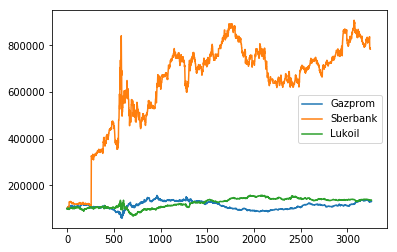

In [13]:
_=plt.plot(range(len(gazp_result)), gazp_result, label = 'Gazprom')
_=plt.plot(range(len(sber_result)), sber_result, label = 'Sberbank')
_=plt.plot(range(len(luko_result)), luko_result, label = 'Lukoil')
_=plt.legend()

## Cross-validation of the strategy

In [14]:
gazp_test = gazp.copy()
gazp_test.index = range(len(gazp_test))
parts = lambda lst, size: [lst[i:i+size] for i in range(0, len(lst), size)]
parts(gazp_test.index, 500)
num = 1
res = DF()
for i in parts(gazp_test.index, 500):
    temp = gazp_test.loc[i]
    c = 100000
    position = 0
    shares = 0
    step = 100
    start = 0
    finish = start + step
    gazp_test_result = []
    while finish < len(temp):
        # block of calculation
        train = temp.iloc[start:finish, :]
        x_train = train.drop('grow', axis=1)
        y_train = train.grow
        clf.fit(x_train, y_train)
        test = DF(temp.iloc[finish, :]).T
        x_test = test.drop('grow', axis=1)
        y_test = test.grow
        start += 1
        finish += 1
        y_pred = clf.predict(x_test)[0]
        # close position block
        if position != 0:
            c += shares * int(x_test['<OPEN>'])
            gazp_test_result.append(c)
            position = 0
        # open position block
        if y_pred == 1:
            if position == 0:
                shares = c // int(x_test['<CLOSE>'])
                c -= shares * int(x_test['<CLOSE>'])
                position = 1
            else:
                continue
        if y_pred == 0:
            if position == 0:
                shares = c // -int(x_test['<CLOSE>'])
                c -= shares * int(x_test['<CLOSE>'])
                position = -1
            else:
                continue
    if len(gazp_test_result) != 500:
        gazp_test_result.extend([float('nan') for i in range(len(gazp_test_result), 500)])
    res['test'+str(num)] = gazp_test_result
    num +=1

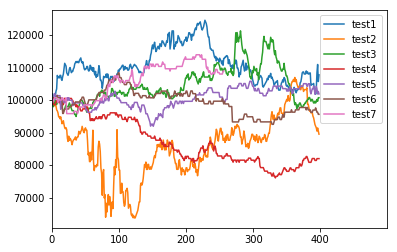

In [15]:
res.plot()

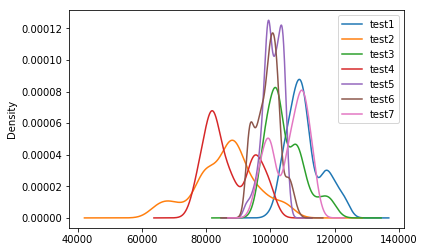

In [16]:
res.plot.kde()

In [17]:
sber_test = sber.copy()
sber_test.index = range(len(sber_test))
parts = lambda lst, size: [lst[i:i+size] for i in range(0, len(lst), size)]
parts(sber_test.index, 500)
num = 1
res = DF()
for i in parts(sber_test.index, 500):
    temp = sber_test.loc[i]
    c = 100000
    position = 0
    shares = 0
    step = 100
    start = 0
    finish = start + step
    sber_test_result = []
    while finish < len(temp):
        # block of calculation
        train = temp.iloc[start:finish, :]
        x_train = train.drop('grow', axis=1)
        y_train = train.grow
        clf.fit(x_train, y_train)
        test = DF(temp.iloc[finish, :]).T
        x_test = test.drop('grow', axis=1)
        y_test = test.grow
        start += 1
        finish += 1
        y_pred = clf.predict(x_test)[0]
        # close position block
        if position != 0:
            c += shares * int(x_test['<OPEN>'])
            sber_test_result.append(c)
            position = 0
        # open position block
        if y_pred == 1:
            if position == 0:
                shares = c // int(x_test['<CLOSE>'])
                c -= shares * int(x_test['<CLOSE>'])
                position = 1
            else:
                continue
        if y_pred == 0:
            if position == 0:
                shares = c // -int(x_test['<CLOSE>'])
                c -= shares * int(x_test['<CLOSE>'])
                position = -1
            else:
                continue
    if len(sber_test_result) != 500:
        sber_test_result.extend([float('nan') for i in range(len(sber_test_result), 500)])
    res['test'+str(num)] = sber_test_result
    num +=1

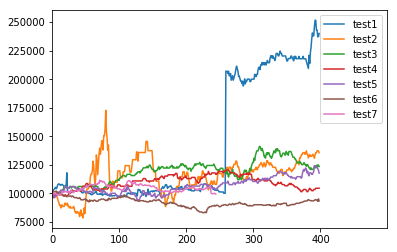

In [18]:
res.plot()

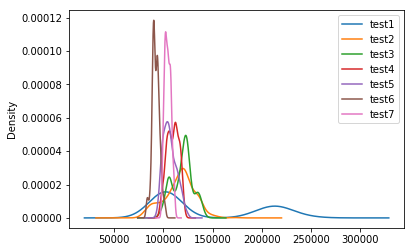

In [19]:
res.plot.kde()

In [20]:
luko_test = luko.copy()
luko_test.index = range(len(luko_test))
parts = lambda lst, size: [lst[i:i+size] for i in range(0, len(lst), size)]
parts(luko_test.index, 500)
num = 1
res = DF()
for i in parts(luko_test.index, 500):
    temp = luko_test.loc[i]
    c = 100000
    position = 0
    shares = 0
    step = 100
    start = 0
    finish = start + step
    luko_test_result = []
    while finish < len(temp):
        # block of calculation
        train = temp.iloc[start:finish, :]
        x_train = train.drop('grow', axis=1)
        y_train = train.grow
        clf.fit(x_train, y_train)
        test = DF(temp.iloc[finish, :]).T
        x_test = test.drop('grow', axis=1)
        y_test = test.grow
        start += 1
        finish += 1
        y_pred = clf.predict(x_test)[0]
        # close position block
        if position != 0:
            c += shares * int(x_test['<OPEN>'])
            luko_test_result.append(c)
            position = 0
        # open position block
        if y_pred == 1:
            if position == 0:
                shares = c // int(x_test['<CLOSE>'])
                c -= shares * int(x_test['<CLOSE>'])
                position = 1
            else:
                continue
        if y_pred == 0:
            if position == 0:
                shares = c // -int(x_test['<CLOSE>'])
                c -= shares * int(x_test['<CLOSE>'])
                position = -1
            else:
                continue
    if len(luko_test_result) != 500:
        luko_test_result.extend([float('nan') for i in range(len(luko_test_result), 500)])
    res['test'+str(num)] = luko_test_result
    num +=1

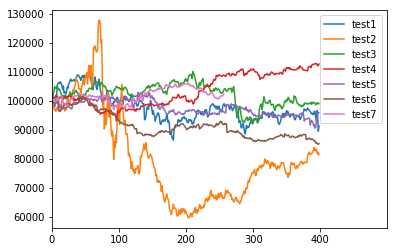

In [21]:
res.plot()

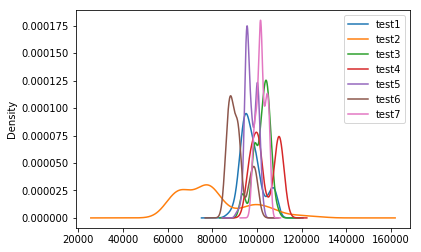

In [22]:
res.plot.kde()

## As you can see, the result of the strategy may depend heavily on the selected period, to reduce the risk, we will try to form a portfolio of these three assets.

In [23]:
cap = 100000
dataframe_names = ['gazp', 'sber', 'luko']
data_result_names = ['gazp_res', 'sber_res', 'luko_res']
weight = [.33, .33, .34]
num = 0
for data_name in dataframe_names:
    capital = cap * weight[num]
    globals()[data_result_names[num]] = DF()
    position = 0
    shares = 0
    step = 100
    result = []
    for finish in range(step, len(globals()[data_name])):
        # block of calculation
        start = finish - step
#         print(start, ':', finish, ':', len(globals()[data_name])-1, sep='', end='|')
        train = globals()[data_name].iloc[start:finish, :]
        x_train = train.drop('grow', axis=1)
        y_train = train.grow
        clf.fit(x_train, y_train)
        test = DF(globals()[data_name].iloc[finish, :]).T
        x_test = test.drop('grow', axis=1)
        y_test = test.grow
        y_pred = clf.predict(x_test)[0]
        # close position block
        if position != 0:
            capital += shares * int(x_test['<OPEN>'])
            result.append(capital)
            position = 0
        # open position block
        if y_pred == 1:
            if position == 0:
                shares = capital // int(x_test['<CLOSE>'])
                capital -= shares * int(x_test['<CLOSE>'])
                position = 1
            else:
                continue
        if y_pred == 0:
            if position == 0:
                shares = capital // -int(x_test['<CLOSE>'])
                capital -= shares * int(x_test['<CLOSE>'])
                position = -1
            else:
                continue
    globals()[data_result_names[num]]['Result'] = result
    num += 1

0:100:3357|1:101:3357|2:102:3357|3:103:3357|4:104:3357|5:105:3357|6:106:3357|7:107:3357|8:108:3357|9:109:3357|10:110:3357|11:111:3357|12:112:3357|13:113:3357|14:114:3357|15:115:3357|16:116:3357|17:117:3357|18:118:3357|19:119:3357|20:120:3357|21:121:3357|22:122:3357|23:123:3357|24:124:3357|25:125:3357|26:126:3357|27:127:3357|28:128:3357|29:129:3357|30:130:3357|31:131:3357|32:132:3357|33:133:3357|34:134:3357|35:135:3357|36:136:3357|37:137:3357|38:138:3357|39:139:3357|40:140:3357|41:141:3357|42:142:3357|43:143:3357|44:144:3357|45:145:3357|46:146:3357|47:147:3357|48:148:3357|49:149:3357|50:150:3357|51:151:3357|52:152:3357|53:153:3357|54:154:3357|55:155:3357|56:156:3357|57:157:3357|58:158:3357|59:159:3357|60:160:3357|61:161:3357|62:162:3357|63:163:3357|64:164:3357|65:165:3357|66:166:3357|67:167:3357|68:168:3357|69:169:3357|70:170:3357|71:171:3357|72:172:3357|73:173:3357|74:174:3357|75:175:3357|76:176:3357|77:177:3357|78:178:3357|79:179:3357|80:180:3357|81:181:3357|82:182:3357|83:183:3357|84

In [35]:
gazp_res['Merge_index'] = gazp_res.index
sber_res['Merge_index'] = sber_res.index
luko_res['Merge_index'] = luko_res.index
data_frames = [gazp_res, sber_res, luko_res]
main = reduce(lambda  left,right: pd.merge(left,right,on=['Merge_index'],how='outer'), data_frames)
del main['Merge_index']
main.columns = data_result_names
main['summ'] = main.sum(axis=1)
main.head()

,gazp_res,sber_res,luko_res,summ
0,32492.0,33455.0,34589.0,100536.0
1,32615.0,33455.0,34703.0,100773.0
2,31995.0,33455.0,33641.0,99091.0
3,31995.0,33455.0,33713.0,99163.0
4,31995.0,33455.0,33443.0,98893.0
